In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE

import warnings 
warnings.filterwarnings("ignore")

## Data loading and preprocessing

In [2]:
df = pd.read_csv("../Data/clean_data.csv")
df.head()

,company_name,issue_amount_(rs.cr.),assets_(rs.cr.),revenue_(rs.cr.),profit_after_tax_(rs.cr.),net_worth_(rs.cr.),reserves_and_surplus_(rs.cr.),total_borrowing_(rs.cr.),issue_price_(rs),sub,gmp,anchor,listing_gains
0,Game Changers Texfab,52.08,52.25,24.11,4.27,25.27,12.76,9.88,102,1.17,1.0,1.0,True
1,Jayesh Logistics,27.17,65.22,25.25,2.02,19.35,13.01,29.65,122,65.59,92.0,1.0,False
2,Sihora Industries,10.03,15.90,5.86,0.45,5.71,1.98,5.71,66,1.27,1.0,0.0,True
3,Mittal Sections,50.26,50.48,28.17,1.47,11.81,3.94,20.70,143,2.25,1.0,0.0,False
4,Greenleaf Envirotech,20.75,25.38,39.08,4.70,12.41,7.79,2.49,136,3.84,1.0,0.0,False


In [3]:
df.shape

(514, 13)

In [4]:
df.isnull().sum()

company_name                       0
issue_amount_(rs.cr.)              0
assets_(rs.cr.)                    0
revenue_(rs.cr.)                   1
profit_after_tax_(rs.cr.)          1
net_worth_(rs.cr.)                 5
reserves_and_surplus_(rs.cr.)    197
total_borrowing_(rs.cr.)         209
issue_price_(rs)                   0
sub                               70
gmp                               70
anchor                            70
listing_gains                      0
dtype: int64

In [5]:
list(df.columns)

['company_name',
 'issue_amount_(rs.cr.)',
 'assets_(rs.cr.)',
 'revenue_(rs.cr.)',
 'profit_after_tax_(rs.cr.)',
 'net_worth_(rs.cr.)',
 'reserves_and_surplus_(rs.cr.)',
 'total_borrowing_(rs.cr.)',
 'issue_price_(rs)',
 'sub',
 'gmp',
 'anchor',
 'listing_gains']

In [6]:
company_name = df["company_name"]
df = df.drop("company_name", axis=1)

In [7]:
# df = df[['issue_amount_(rs.cr.)',
#  'profit_after_tax_(rs.cr.)',
#  'net_worth_(rs.cr.)',
#  'issue_price_(rs)',
#  'listing_day_close_price',
#  'sub',
#  'gmp',
#  'anchor']]

In [8]:
df.fillna(0, inplace=True)

## Exploratory Data Analysis

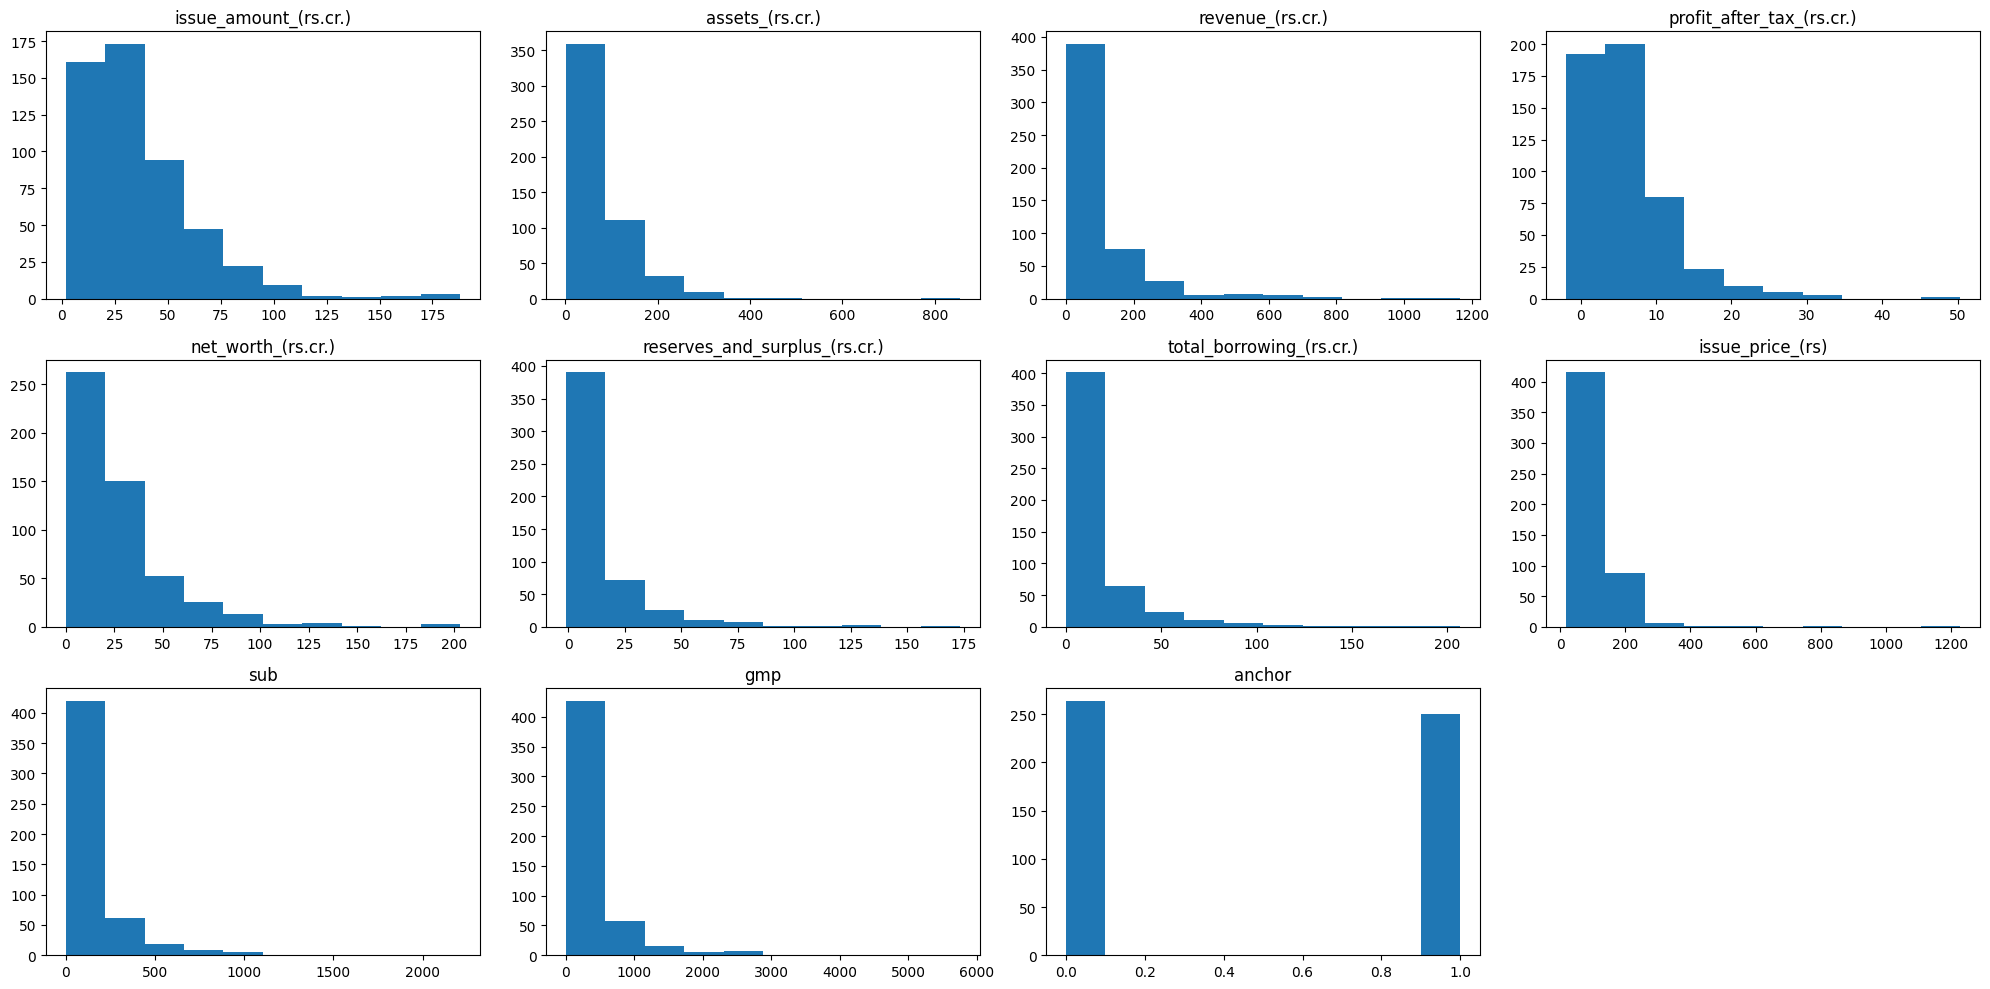

In [9]:
features = ['issue_amount_(rs.cr.)','assets_(rs.cr.)','revenue_(rs.cr.)','profit_after_tax_(rs.cr.)',
 'net_worth_(rs.cr.)','reserves_and_surplus_(rs.cr.)','total_borrowing_(rs.cr.)','issue_price_(rs)',
 'sub','gmp','anchor']
n_features = len(features)

fig, axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.flatten()   

for i, feature in enumerate(features):
    if i < len(axes):
        axes[i].hist(df[feature].dropna())
        axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

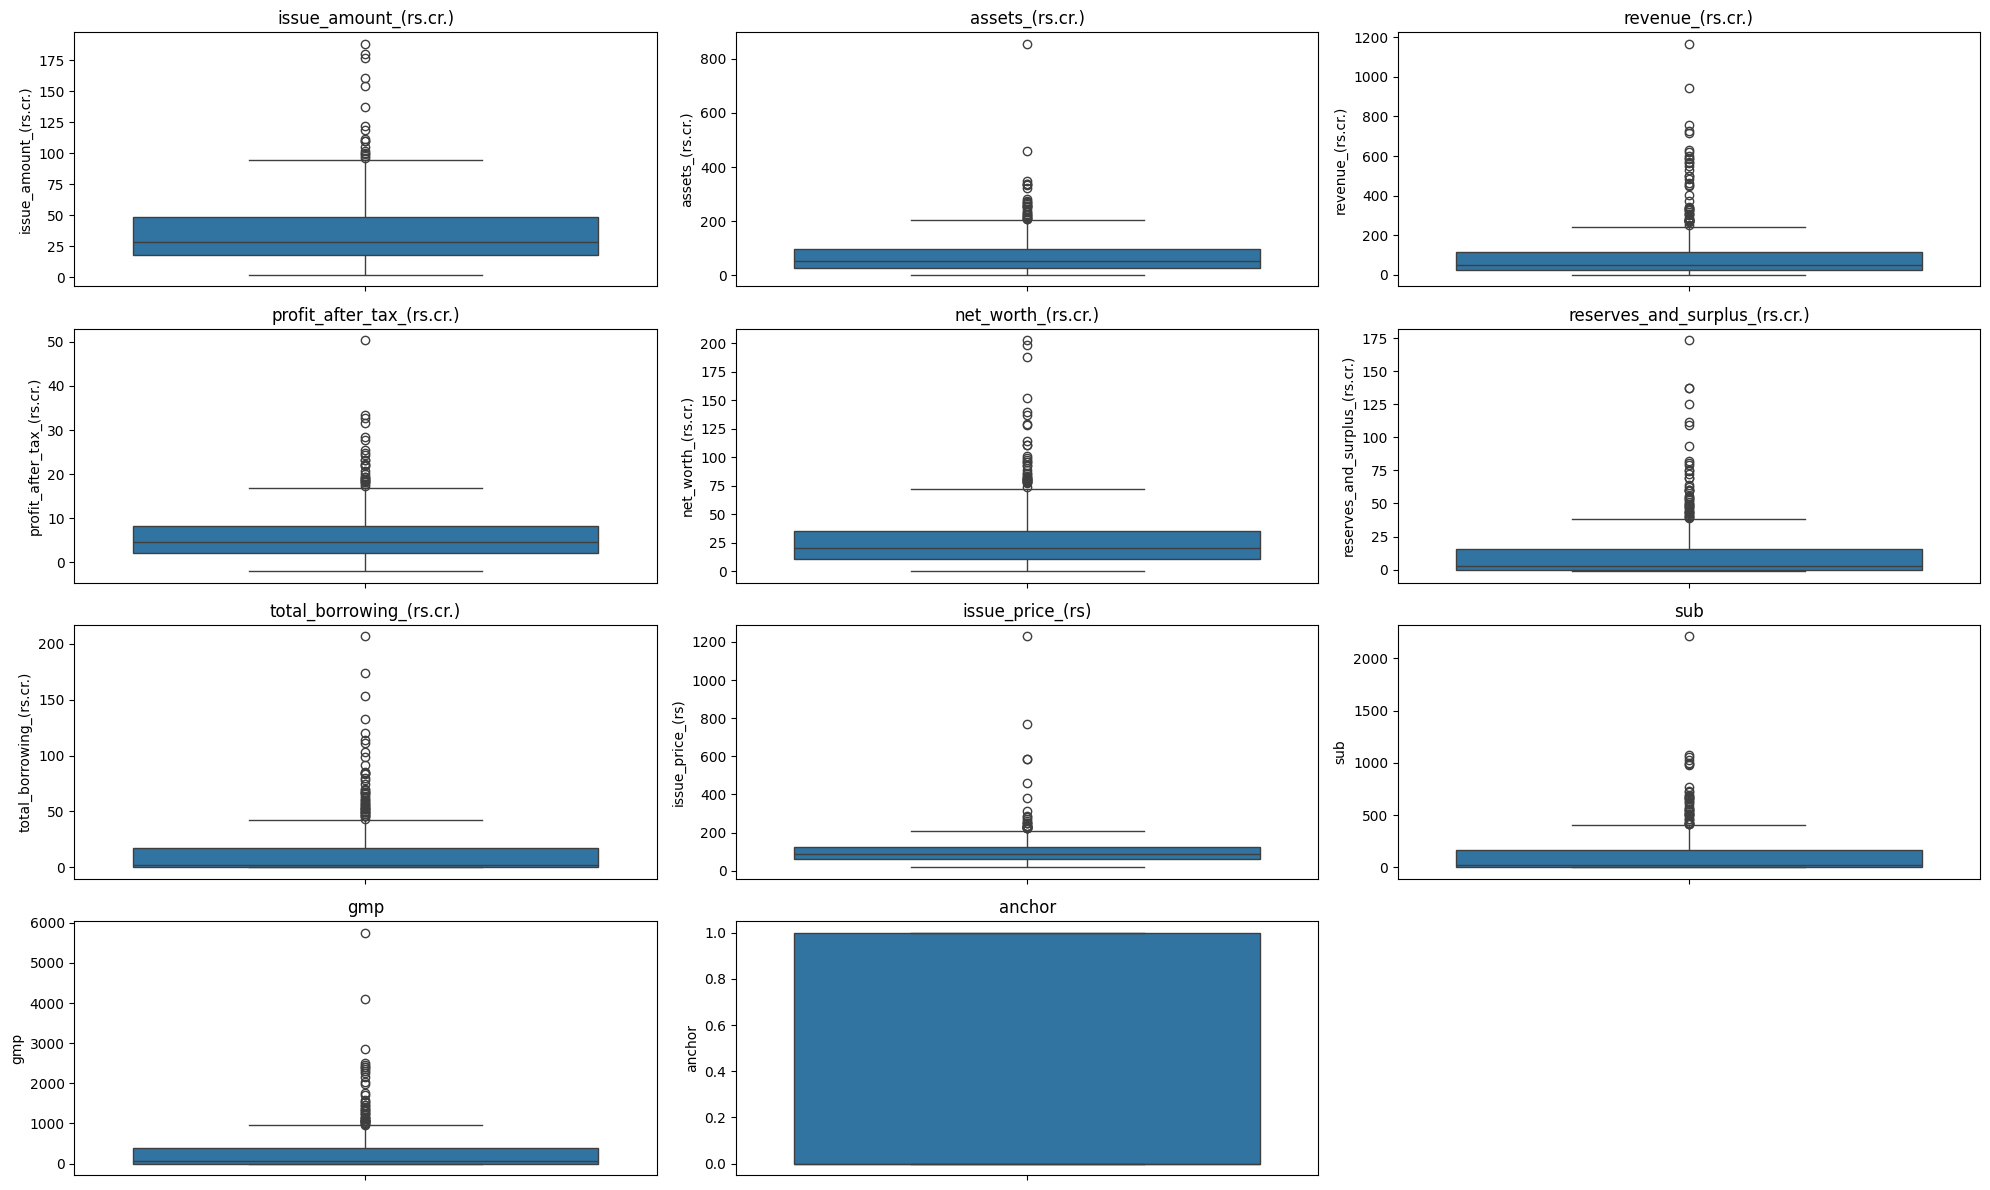

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(20, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    if i < len(axes):
        sns.boxplot(y=df[feature], ax=axes[i])
        axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### The outliers are no errors and found to be realistic values. Therefore not treating these outliers ⬆️


In [11]:
pd.merge(company_name, df[df["sub"] > 1000],right_index=True, left_index=True)


,company_name,issue_amount_(rs.cr.),assets_(rs.cr.),revenue_(rs.cr.),profit_after_tax_(rs.cr.),net_worth_(rs.cr.),reserves_and_surplus_(rs.cr.),total_borrowing_(rs.cr.),issue_price_(rs),sub,gmp,anchor,listing_gains
51,Austere Systems,14.78,18.63,18.86,4.01,16.27,8.62,0.48,55,1076.99,325.0,1.0,True
182,NACDAC Infrastructure,9.24,30.23,13.76,1.60,13.61,0.00,0.00,35,2209.76,505.0,1.0,True
183,Hamps Bio,5.91,6.44,4.36,0.34,3.71,0.00,0.00,51,1057.00,605.0,0.0,True
187,Toss The Coin,8.70,5.95,4.39,1.16,4.99,0.00,0.00,182,1025.76,2145.0,1.0,True


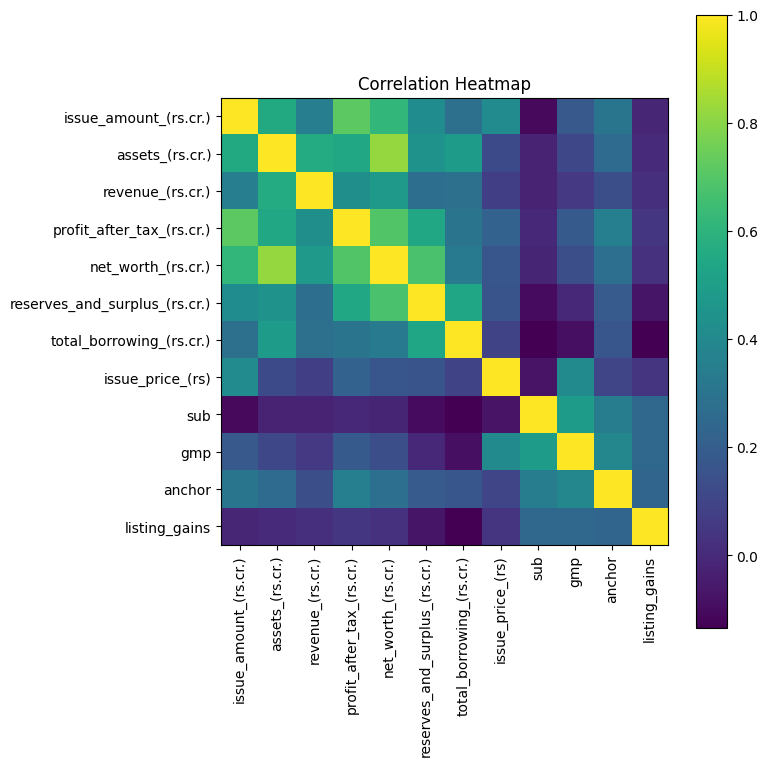

In [12]:
plt.figure(figsize=(8, 8))

corr = df.corr().values
features = df.corr().columns

plt.imshow(corr, interpolation='nearest')
plt.colorbar()

plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### Correlation between assets and net worth is high as one can be dervived from another. ⬆️


## Model training

In [13]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

In [14]:
df_train.shape, df_test.shape

((462, 12), (52, 12))

In [15]:
y_train = df_train["listing_gains"]
y_test = df_test["listing_gains"]

In [16]:
del df_train["listing_gains"]
del df_test["listing_gains"]

In [17]:
X_train = df_train
X_test = df_test

## Using  Recall macro score as criteria for comparison. Recall macro give a single measure for precision and recall of both classes

## Training baseline models

In [32]:

# -------------------
# Stratified K-Fold for imbalanced data
# -------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------
# Class imbalance values
# -------------------
pos = sum(y_train == 1)   # gains
neg = sum(y_train == 0)   # losses
scale_pos_weight = neg / pos  # for XGBoost

models = [
    LogisticRegression(class_weight="balanced", max_iter=500),
    RandomForestClassifier(class_weight="balanced", n_estimators=300),
    XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        use_label_encoder=False
    )
]

model_names = ["lr", "rf", "xgb"]

recall_macro_scores = {}

print("** Training baseline models **\n")
print("="*100)

for name, model in zip(model_names, models):

    scores = cross_val_score(
        model, X_train, y_train,
        cv=skf,
        scoring="recall_macro"   
    )

    recall_macro_scores[name] = scores.mean().round(3)

    print(name.upper())
    print("Recall Macro Scores:", scores.round(3))
    print("Mean Recall Macro:", scores.mean().round(3))
    print("="*100)


** Training baseline models **

LR
Recall Macro Scores: [0.744 0.749 0.688 0.681 0.703]
Mean Recall Macro: 0.713
RF
Recall Macro Scores: [0.629 0.638 0.579 0.608 0.579]
Mean Recall Macro: 0.607
XGB
Recall Macro Scores: [0.553 0.682 0.517 0.624 0.588]
Mean Recall Macro: 0.592


## Training with RandomizedSearchCV for hyper-parameter tuning.

In [33]:

# -------------------
# Models
# -------------------
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss'
)

# -------------------
# Hyperparameter distributions
# -------------------
param_dist = {
    'lr': {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': uniform(0.01, 10),
        'solver': ['saga'],
        'max_iter': [200, 500, 1000]
    },
    'rf': {
        'n_estimators': randint(100, 500),
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4),
    },
    'xgb': {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
    }
}

best_models = {}
best_scores = {}

print("="*100)
print(" Hyperparameter Tuning (scoring = f1_macro) ")
print("="*100)

for model_name, model in zip(['lr','rf','xgb'], [lr, rf, xgb]):
    print(f"Tuning {model_name}...")

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist[model_name],
        n_iter=25,
        scoring='recall_macro',       
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)

    best_models[model_name] = search.best_estimator_
    best_scores[model_name] = search.best_score_

    print(f"Best params for {model_name}: {search.best_params_}")
    print(f"Best f1_macro for {model_name}: {search.best_score_}\n")
    print("="*100)


 Hyperparameter Tuning (scoring = f1_macro) 
Tuning lr...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params for lr: {'C': np.float64(0.017787658410143285), 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Best f1_macro for lr: 0.7131691672102631

Tuning rf...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params for rf: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 113}
Best f1_macro for rf: 0.6974440095672972

Tuning xgb...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params for xgb: {'learning_rate': np.float64(0.021282315805420053), 'max_depth': 6, 'n_estimators': 393}
Best f1_macro for xgb: 0.5967965862143945



## Model Selection

In [36]:
scores_matrix = pd.DataFrame([recall_macro_scores,best_scores], index=["baseline","tuned"])
scores_matrix

,lr,rf,xgb
baseline,0.713000,0.607000,0.592000
tuned,0.713169,0.697444,0.596797


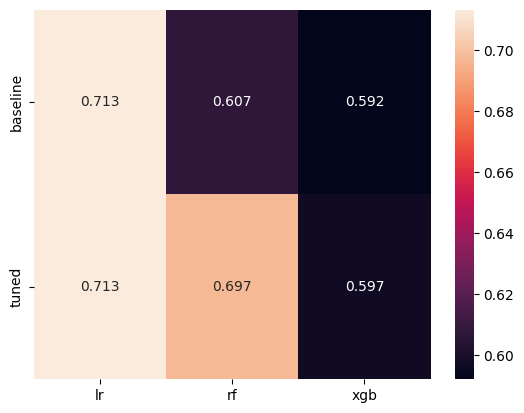

In [37]:
sns.heatmap(scores_matrix, annot=True, fmt=".3f")
plt.show()

## Selecting tuned logistic regression as the macro f1 is highest

In [38]:
final_model = best_models["lr"]

In [45]:
pd.DataFrame({"features":final_model.feature_names_in_, "importance":final_model.coef_[0]}).sort_values("importance", ascending=False)

,features,importance
9,gmp,0.006207
8,sub,0.001293
2,revenue_(rs.cr.),0.000000
10,anchor,0.000000
4,net_worth_(rs.cr.),0.000000
3,profit_after_tax_(rs.cr.),0.000000
1,assets_(rs.cr.),-0.001220
5,reserves_and_surplus_(rs.cr.),-0.001247
6,total_borrowing_(rs.cr.),-0.002659
0,issue_amount_(rs.cr.),-0.003372


In [31]:
import pickle

In [ ]:
with open("model.bin", "wb") as f_out:
    pickle.dump(final_model, f_out)

Best Params (xgb): 
{'colsample_bytree': np.float64(0.8099085529881075), 
 'learning_rate': np.float64(0.10121399684340719), 
 'max_depth': 9, 
 'n_estimators': 150, 
 'scale_pos_weight': 10, 
 'subsample': np.float64(0.8542703315240834)
}